#Imports and Methods

In [27]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, callbacks
#import plotext as plt
import math
import random
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import matplotlib.pyplot as mpl
import plotext as plt
import sklearn
from sklearn.model_selection import train_test_split
import statistics
from scipy.fft import fft, ifft
import seaborn as sns
import springmass_multi
import springmass_gen
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import binned_statistic
from keras import ops



In [70]:
#TO-DO
#plot singular variable errors (damping, d0,d1,d2,d3,d4,omega)
#if find no special error patterns -->increase data and gaussian noise
#


# Define training and validation data
dt = 0.01 #blew up at 0.125
#blew up with 0.01
#use polynomial expansion in runge kutta to determine exact dt
input_size = 400
end_time = 60
steps = int(end_time / dt)
downsample_rate = math.ceil(int(steps / input_size))

# Setting random values of k  and m ;-;
k=1.0
m=1.0

In [56]:
class SpringMassOLD:
    def __init__(self, k, b, m):
        self.k = k
        self.b = b
        self.m = m
        self.x = 1.0
        self.v = 0.0

    def generateSignal(self, t, timesteps):
        #freqs = np.linspace(0.1, 10, timesteps) #will generate array of evenly values
        #signal = np.sum([np.sin(2 * np.pi * f * t) + np.cos(2*np.pi*f*t) for f in freqs])
        #print(signal)
        #return signal

        omega = 1
        d0=0
        d1=1
        d2=2
        d3=3
        d4=4
        t = 0

        stepSignal = (8 *np.pi)/15


        signals = [] 

        while(t != 8*3.1415):
            signals.append(d0 + d1*np.cos(omega*t) + d2* np.sin(omega*t) + d3*np.cos(2*omega*t) + d4*np.sin(2*omega*t))
            t+=stepSignal
        return signal
        

    def d(self, t): #fft algorithm on disturbance

        steps=60
        signal = self.generateSignal(t, steps)


        fft_result = fft(signal)
        

        #ifft_result = ifft(fft_result)
        return np.real(fft_result)

    def accel(self, x, v, t):
        # mx'' + bx' + kx = d(t)
        # x'' = (d(t) - bx' - kx) / m
        return (- self.b * v - self.k * x) / self.m

    def step_rk4(self, t, dt):
        v1 = self.v
        x1 = self.x
        a1 = self.accel(self.x, self.v, t)

        v2 = v1 + (dt/2) * a1
        x2 = x1 + (dt/2) * v1
        a2 = self.accel(x2, v2, t + (dt/2))

        v3 = v1 + (dt/2) * a2
        x3 = x1 + (dt/2) * v2
        a3 = self.accel(x3, v3, t + (dt/2))

        v4 = v1 + dt * a3
        x4 = x1 + dt * v3
        a4 = self.accel(x4, v4, t + dt)

        self.v = self.v + dt * (a1 + a2 * 2 + a3 * 2 + a4) / 6
        self.x = self.x + dt * (v1 + v2 * 2 + v3 * 2 + v4) / 6

    def step_euler(self, dt):
        a = self.accel(self.x, self.v)
        self.x = self.x + dt * self.v
        self.v = self.v + dt * a

    def step_midpoint(self, dt):
        a = self.accel(self.x,self.v)
        v_m = self.v + (dt/2)*a
        x_m = self.x + (dt/2)*self.v
        a_m = self.accel(x_m, v_m)

        self.x = self.x + dt*v_m
        self.v = self.v + dt*a_m

    '''def step_rk4(self, dt):
        v1 = self.v
        x1 = self.x
        a1 = self.accel(self.x, self.v)

        v2 = v1 + (dt/2) * a1
        x2 = x1 + (dt/2) * v1
        a2 = self.accel(x2, v2)

        v3 = v1 + (dt/2) * a2
        x3 = x1 + (dt/2) * v1
        a3 = self.accel(x3, v3)

        v4 = v1 + dt * a3
        x4 = x1 + dt * v3
        a4 = self.accel(x4, v4)

        self.v = self.v + dt * (a1 + a2 * 2 + a3 * 2 + a4) / 6
        self.x = self.x + dt * (v1 + v2 * 2 + v3 * 2 + v4) / 6
    '''

    def pos(self, t):
        # returns position x(t) given t
        # mu = b / 2m
        # omega_0^2 = k / m
        # gamma = sqrt(omega_0^2 - mu^2)
        # phi = atan(-mu / gamma)
        #     = atan2(-mu, gamma)
        # 𝜙 = atan(-𝜇/𝛾)
        # a = h * sqrt(1 + (mu/gamma)^2)
        # x = a * e^(mu*t) * cos(gamma * t + phi)
        mu = self.b / (2 * self.m)
        omega_not = math.sqrt(self.k / self.m)
        if(mu**2 -omega_not**2>0):
            gamma = math.sqrt(mu**2-omega_not**2)
            alpha = mu+gamma
            beta = mu-gamma
            return (self.x/(2*gamma))*((alpha)*math.exp(-(beta)*t)-(beta)*math.exp(-alpha*t))
        elif(mu**2-omega_not**2==0):
            return self.x*(math.exp(-mu*t))+ self.x*mu*t*(math.exp(-mu*t))
        elif(mu**2-omega_not**2<0):
            gamma = math.sqrt(omega_not**2 - mu**2)
            phi = math.atan2(-mu, gamma)
            a = self.x * (math.sqrt((mu/gamma)**2 + 1))
            return a * (math.exp(-mu * t) * math.cos(gamma * t + phi))

In [2]:
class SpringMass:
    def __init__(self, k, b, m, d0, d1, d2, d3, d4, omega):
        self.k = k
        self.b = b
        self.m = m
        self.x = 1.0
        self.v = 0.0

        self.d0=d0
        self.d1=d1
        self.d2=d2
        self.d3=d3
        self.d4=d4
        self.omega=omega
        
    def d(self, t):
        omega = self.omega
        return self.d0 + self.d1 * np.cos((2*np.pi)*omega*t) + self.d2 * np.sin((2*np.pi)*omega*t) + self.d3 * np.cos((2*np.pi)*2*omega*t) + self.d4 * np.sin((2*np.pi)*2*omega*t)

    def accel(self, x, v, t):
        # mx'' + bx' + kx = d(t)
        # x'' = (d(t) - bx' - kx) / m
        return (self.d(t) - self.b * v - self.k * x) / self.m

    def step_rk4(self, t, dt):
        # d(t) = 0
        # m = 1
        # k = 1

        # at t = 0:
        # v1 = 0
        # x1 = 1
        v1 = self.v
        x1 = self.x
        # a1 = (-b v1 - k x1) / m
        a1 = self.accel(self.x, self.v, t)

        # v2 = v1 + (dt/2) * a1 = v1 + (dt/2) * (-b v1 - k x1) / m = v1 - (b*v1*v2 - k*x1*dt)/2m
        v2 = v1 + (dt/2) * a1
        # x2 = x1 + (dt/2) * v1 = x1 + (dt*v1)/2
        x2 = x1 + (dt/2) * v1
        # a2 = (-b v2 - k x2) = -b (v1 - (dt * b * v1 - dt * x1)) - k * x2
        a2 = self.accel(x2, v2, t + (dt/2))

        # v3 = v1 + 0.05 * 4 = 0.2
        v3 = v1 + (dt/2) * a2
        # original:
        # x3 = x1 + 0.05 * v1 = 1
        # fixed:
        # x3 = x1 + 0.05 * v2 = 1 + (-0.05 * 0.05) = .9975
        x3 = x1 + (dt/2) * v2
        # a3 = (-b v3 - k x3) / m = -(100*0.2 - 1*0.9975)/1 = -20 - .9975 = -20.9975
        a3 = self.accel(x3, v3, t + (dt/2))

        # v4 = v1 + 0.1 * -20.9975 = -2.09975
        v4 = v1 + dt * a3
        # x4 = x1 + 0.1 * 0.2 = 1.02
        x4 = x1 + dt * v3
        # a4 = (-b v4 - k x4) / m =  -(100*-2.09975 + 1.02)/1 = 208.955
        a4 = self.accel(x4, v4, t + dt)

        # v = v1 + 0.1 * (-1 + 2 * 4 + 2 * -20.9975 + 208.955) / 6 = 2.899
        self.v = self.v + dt * (a1 + a2 * 2 + a3 * 2 + a4) / 6
        # x = x1 + 0.1 * (0 + -0.05 * 2 + 0.2 * 2 + -2.09975) / 6 = 0.97
        self.x = self.x + dt * (v1 + v2 * 2 + v3 * 2 + v4) / 6
        #print(f"x: {self.x}, v: {self.v}, a1: {a1}, a2: {a2}, a3: {a3}, a4: {a4}")
        return self.x
    
# mx'' + bx' + kx = 0
# x'' = acceleration
# F = ma
# mx'' = acceleration force
# bx' = damping force
# kx = spring force
#
# mx'' + bx' + kx = d(t)
# d(t) = disturbance force

#b_values = [0.04, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.22, 2.50, 2.84, 3.34, 4.0, 5.0, 6.66, 10.0, 20.0, 40.0, 100.0]
# b_values= [round(random.uniform(0.04,2), 2) for _ in range(30)] + [round(random.uniform(2, 20),2) for _ in range(20)]
#plot using lograthmic scale

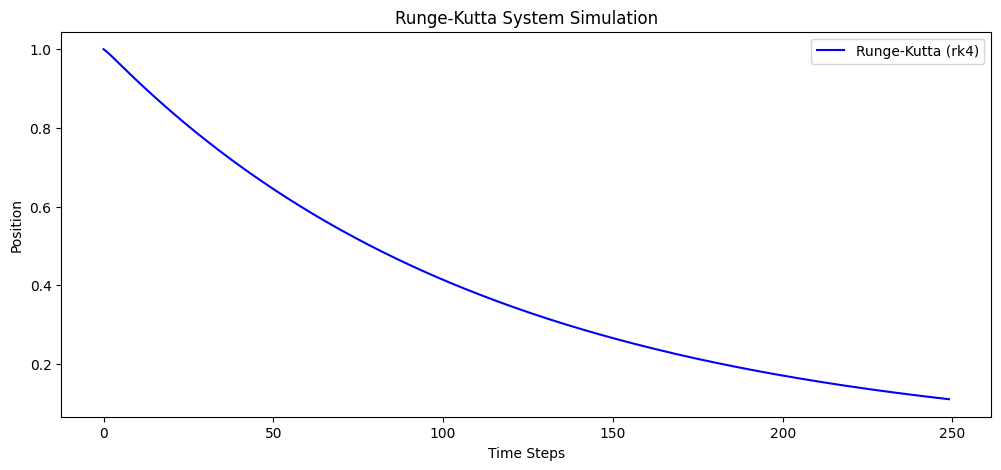

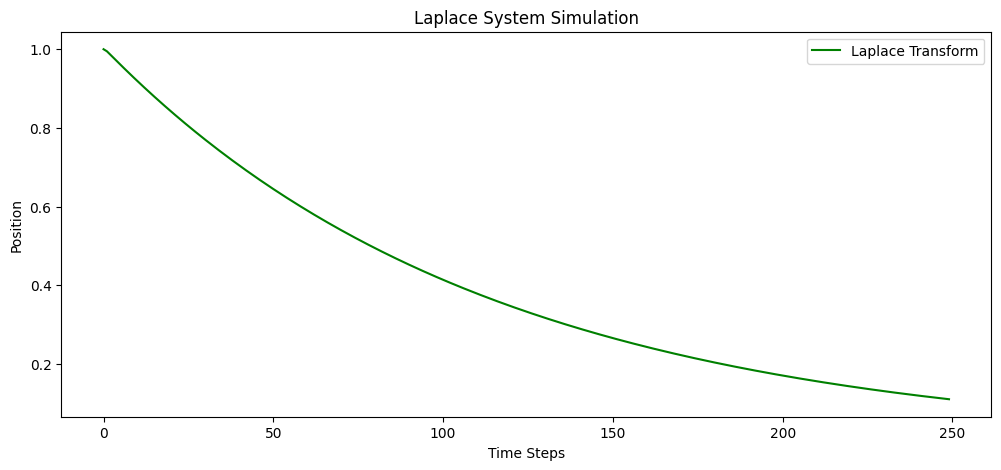

0.0011241747026256247


In [35]:
#strut stuff
#to determine damping condition need to solve for zeta
#zeta = b/(2(sqrt(mk)))
#zeta=1 -->critically damped
#0<zeta<1 --> under-damped
# zeta>1 -->overdamped 

# mu = b / 2m
# omega_0 = sqrt(k / m)
# zeta = mu / omega_0 = (b / 2m) / (sqrt(k / m))
# zeta = b / (2m * sqrt(k / m))
# zeta = b / (2 * sqrt(km))
system_r = SpringMassOLD(38700.000, 175501.3191663242, 3108.9221)  # k=1, b=3, m=1
system_actual = SpringMassOLD(38700.000, 175501.3191663242, 3108.9221)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    non_zero_indices = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    return mape

dt = 0.04
steps = 250
time = []
for i in range(10):
    time.append(i)
positions_r = []
positions_actual = [system_actual.pos(n * dt) for n in range(steps)]
    
for t in range(steps):
    positions_r.append(system_r.x)
    system_r.step_rk4(dt * t, dt)

mpl.figure(figsize=(12, 5))
mpl.plot(positions_r, label='Runge-Kutta (rk4)', color='blue')  # Blue line for rk4
mpl.xlabel("Time Steps")
mpl.ylabel("Position")
mpl.legend()
mpl.title("Runge-Kutta System Simulation")
mpl.show()

mpl.figure(figsize=(12, 5))
mpl.plot(positions_actual, label='Laplace Transform', color='green')  # Blue line for rk4
mpl.xlabel("Time Steps")
mpl.ylabel("Position")
mpl.legend()
mpl.title("Laplace System Simulation")
mpl.show()

print(mean_absolute_percentage_error(positions_r, positions_actual))

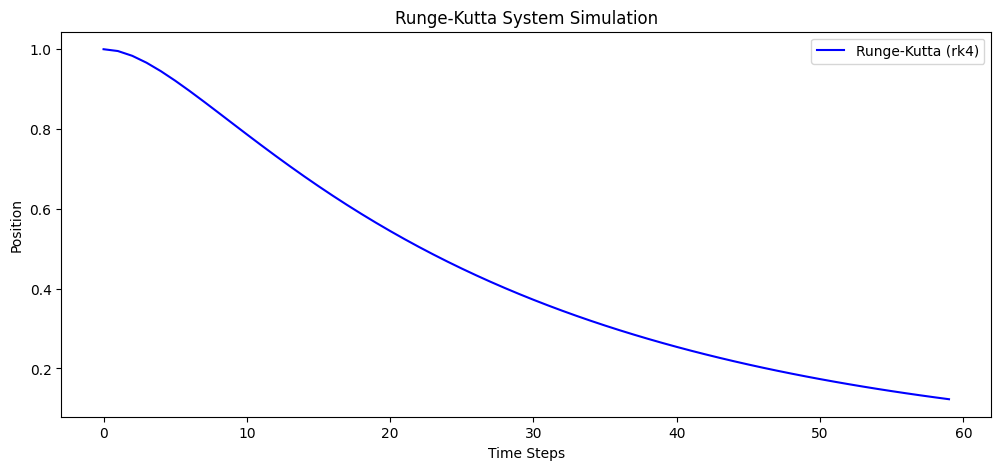

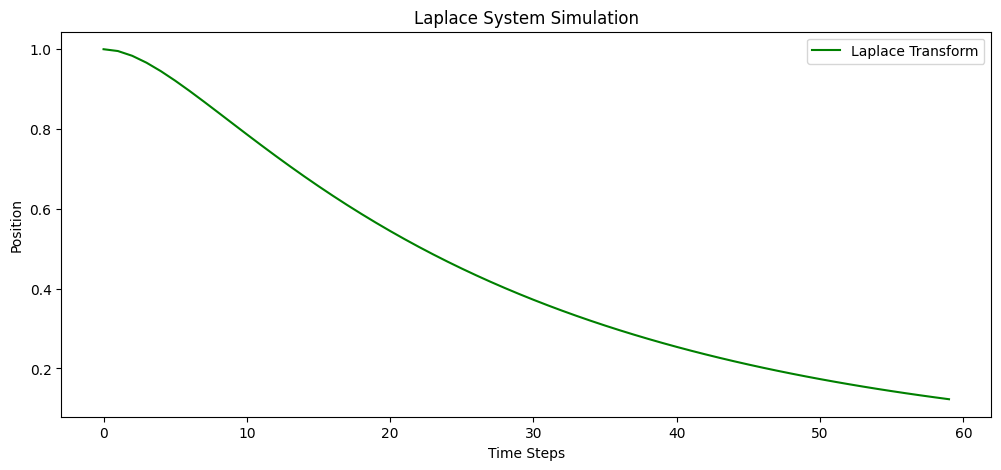

6.436089972954136e-05


In [20]:
#to determine damping condition need to solve for zeta
#zeta = b/(2(sqrt(mk)))
#zeta=1 -->critically damped
#0<zeta<1 --> under-damped
# zeta>1 -->overdamped 

# mu = b / 2m
# omega_0 = sqrt(k / m)
# zeta = mu / omega_0 = (b / 2m) / (sqrt(k / m))
# zeta = b / (2m * sqrt(k / m))
# zeta = b / (2 * sqrt(km))
system_r = SpringMassOLD(1, 3, 1)  # k=1, b=3, m=1
system_actual = SpringMassOLD(1, 3, 1)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    non_zero_indices = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    return mape

dt = 0.1
steps = 60
positions_r = []
positions_actual = [system_actual.pos(n * dt) for n in range(steps)]
    
for t in range(steps):
    positions_r.append(system_r.x)
    system_r.step_rk4(dt * t, dt)

mpl.figure(figsize=(12, 5))
mpl.plot(positions_r, label='Runge-Kutta (rk4)', color='blue')  # Blue line for rk4
mpl.xlabel("Time Steps")
mpl.ylabel("Position")
mpl.legend()
mpl.title("Runge-Kutta System Simulation")
mpl.show()

mpl.figure(figsize=(12, 5))
mpl.plot(positions_actual, label='Laplace Transform', color='green')  # Blue line for rk4
mpl.xlabel("Time Steps")
mpl.ylabel("Position")
mpl.legend()
mpl.title("Laplace System Simulation")
mpl.show()

print(mean_absolute_percentage_error(positions_r, positions_actual))

In [123]:
x_trainSpring, y_trainSpring = springmass_gen.load_data("springmass_data_random_100k")
x_testSpring = x_trainSpring[:-20000]
y_testSpring = y_trainSpring[:-20000]


x_trainStrut, y_trainStrut = springmass_gen.load_data("springmass_strut_5_data_random_100k")
x_testStrut = x_trainStrut[:-20000]
y_testStrut = y_trainStrut[:-20000]

mStrut =  3108.9221
kStrut = 38700
omeganStrut = math.sqrt(kStrut/mStrut)
#b_values_test =  [round(random.uniform(0.04,2), 2) for _ in range(30)] + [round(random.uniform(2, 20),2) for _ in range(10)]

'''b_values = y_train.transpose()[0]
b_values_test = [b_values[i] + random.uniform(-0.04, 0.04) for i in range(10)]
#b_values_test = [0.04, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.22, 2.50, 2.84, 3.34, 4.0, 5.0, 6.66, 10.0, 20.0]
d0_values_test = [-0.5, 0.5]
d1_values_test = [-0.5, 0.5]
d2_values_test = [-0.5, 0.5]
d3_values_test = [-0.5, 0.5]
d4_values_test = [-0.5, 0.5]
omega_values_test = [0.05, 0.1, 0.2, 0.275, 0.35, 0.45]

params_test = np.array(
    [[b, d0, d1, d2, d3, d4, omega]
        for b in b_values_test
        for d0 in d0_values_test
        for d1 in d1_values_test
        for d2 in d2_values_test
        for d3 in d3_values_test
        for d4 in d4_values_test
        for omega in omega_values_test])
b_system_values_test, d0_system_values_test, d1_system_values_test, d2_system_values_test, d3_system_values_test, d4_system_values_test, omega_system_values_test = params_test.transpose()
system_set_test = springmass_multi.SpringMass(
    k, b_system_values_test, m,
    d0_system_values_test,
    d1_system_values_test,
    d2_system_values_test,
    d3_system_values_test,
    d4_system_values_test,
    omega_system_values_test)

x_test = np.array([system_set_test.step_rk4(dt) for a in range(steps)][::downsample_rate]).transpose()
y_test = params_test
'''

'b_values = y_train.transpose()[0]\nb_values_test = [b_values[i] + random.uniform(-0.04, 0.04) for i in range(10)]\n#b_values_test = [0.04, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.22, 2.50, 2.84, 3.34, 4.0, 5.0, 6.66, 10.0, 20.0]\nd0_values_test = [-0.5, 0.5]\nd1_values_test = [-0.5, 0.5]\nd2_values_test = [-0.5, 0.5]\nd3_values_test = [-0.5, 0.5]\nd4_values_test = [-0.5, 0.5]\nomega_values_test = [0.05, 0.1, 0.2, 0.275, 0.35, 0.45]\n\nparams_test = np.array(\n    [[b, d0, d1, d2, d3, d4, omega]\n        for b in b_values_test\n        for d0 in d0_values_test\n        for d1 in d1_values_test\n        for d2 in d2_values_test\n        for d3 in d3_values_test\n        for d4 in d4_values_test\n        for omega in omega_values_test])\nb_system_values_test, d0_system_values_test, d1_system_values_test, d2_system_values_test, d3_system_values_test, d4_system_values_test, omega_system_values_test = params_test.transpose()\nsystem_set_test = springmass_multi.SpringMass(\n  

In [13]:
def make_deep_disturbance_model(layer_sizes=[128,128,128,128,128], epochs=500, learning_rate=0.0005, batch_size=64):
    l = [layers.Dense(units=size, activation="relu", input_shape=[steps if n == 0 else layer_sizes[n - 1]]) for n, size in enumerate(layer_sizes)]


    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0003, # minimium amount of change to count as an improvement
        patience=50, # how many epochs to wait before stopping
        restore_best_weights=True,
    )
    plateau_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 40, factor=0.1)
    noise_layer = layers.GaussianNoise(0.05)
    model = keras.Sequential([
        noise_layer, 
        *l,
        layers.Dense(units=6) #1 unit for each output we are trying to recieve 
    ])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)  # sets training algorithm to correct weights
    model.compile(optimizer=opt, loss='mean_squared_error')  # puts together the model
    
    nn_history = model.fit(x_train, y_train[:,1:], epochs=epochs, validation_split = 0.2, batch_size=batch_size, verbose=1)  # trains model
    
    plt.clear_data()
    plt.clear_color()
    plt.clear_figure()
    plt.plot_size(80, 25)
    plt.plot(nn_history.history['loss'], label='Training Loss')
    plt.plot(nn_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.show() 
    

    return model

In [14]:
def make_deep_damping_model(layer_sizes=[32,32], epochs=500, learning_rate=0.0005, batch_size=64):
    l = [layers.Dense(units=size, activation="relu", input_shape=[steps if n == 0 else layer_sizes[n - 1]]) for n, size in enumerate(layer_sizes)]


    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0003, # minimium amount of change to count as an improvement
        patience=50, # how many epochs to wait before stopping
        restore_best_weights=True,
    )
    plateau_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 40, factor=0.1)
    noise_layer = layers.GaussianNoise(0.05)
    model = keras.Sequential([
        noise_layer, 
        *l,
        layers.Dense(units=1) #1 unit for each output we are trying to recieve 
    ])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)  # sets training algorithm to correct weights
    model.compile(optimizer=opt, loss='mean_absolute_percentage_error')  # puts together the model
    
    nn_history = model.fit(x_train, y_train[:,:1], epochs=epochs, validation_split = 0.2, batch_size=batch_size, verbose=1)  # trains model
    
    plt.clear_data()
    plt.clear_color()
    plt.clear_figure()
    plt.plot_size(80, 25)
    plt.plot(nn_history.history['loss'], label='Training Loss')
    plt.plot(nn_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE Loss')
    plt.show() 
    

    return model

In [15]:
def make_conv_disturbance_model(layer_sizes=[128,128], epochs=500, learning_rate=0.0005, batch_size=64):
    l = [layers.Dense(units=size, activation="relu", input_shape=[None if n == 0 else layer_sizes[n - 1]]) for n, size in enumerate(layer_sizes)]

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0003, # minimium amount of change to count as an improvement
        patience=50, # how many epochs to wait before stopping
        restore_best_weights=True,
    )
    plateau_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 40, factor=0.1)
    noise_layer = layers.GaussianNoise(0.05)
    n_filters = 4
    #conv_layer = layers.Conv1D(filters=n_filters, kernel_size=3)
    #pool_layer = layers.MaxPooling1D(pool_size = 2)
    model = keras.Sequential([
        noise_layer, 
        layers.Reshape((-1, 1)),
        #first version: only one Conv layer. Existent in modelDisturbCNN1 and modelDisturbCNN2
        #conv_layer = layers.Conv1D(filters=n_filters, kernel_size=3)
        #second version:2 conv layer 2 pool layer:
        #conv_layer = layers.Conv1D(filters=n_filters, kernel_size=3)
        #pool_layer = layers.maxPooling1dlayer(kernel_size = 2, stride=1)
        layers.Conv1D(filters=n_filters, kernel_size=9),
        layers.MaxPooling1D(pool_size = 5),
        layers.Conv1D(filters=n_filters, kernel_size=9),
        layers.MaxPooling1D(pool_size = 5),
        layers.Flatten(),
        *l,
       layers.Dense(units=6) #1 unit for each output we are trying to recieve 
    ])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)  # sets training algorithm to correct weights
    model.compile(optimizer=opt, loss='mean_squared_error')  # puts together the model
    
    nn_history = model.fit(x_train, y_train[:,1:], epochs=epochs, validation_split = 0.2, batch_size=batch_size, verbose=1)  # trains model
    
    plt.clear_data()
    plt.clear_color()
    plt.clear_figure()
    plt.plot_size(80, 25)
    plt.plot(nn_history.history['loss'], label='Training Loss')
    plt.plot(nn_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.show() 

    return model

In [16]:
def make_conv_damping_model(layer_sizes=[32,32], epochs=500, learning_rate=0.0005, batch_size=64):
    l = [layers.Dense(units=size, activation="relu", input_shape=[None if n == 0 else layer_sizes[n - 1]]) for n, size in enumerate(layer_sizes)]

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0003, # minimium amount of change to count as an improvement
        patience=50, # how many epochs to wait before stopping
        restore_best_weights=True,
    )
    plateau_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 40, factor=0.1)
    noise_layer = layers.GaussianNoise(0.05)
    conv_layer = layers.Conv1D(filters=4, kernel_size=2)
    model = keras.Sequential([
        noise_layer, 
        layers.Reshape((-1, 1)),
        conv_layer,
        layers.Flatten(),
        *l,
        layers.Dense(units=6) #1 unit for each output we are trying to recieve 
    ])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)  # sets training algorithm to correct weights
    model.compile(optimizer=opt, loss='mean_absolute_percentage_error')  # puts together the model
    
    nn_history = model.fit(x_train, y_train[:,1:], epochs=epochs, validation_split = 0.2, batch_size=batch_size, verbose=1)  # trains model
    
    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(nn_history.history['loss'], label='Training Loss', color='blue')
    plt.plot(nn_history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

In [25]:
def visualizeAmplitudeError(expected, predicted,problem):
    outputs = np.array(predicted)
    
        
    expected = np.array(expected)
   
    
    predicted_amplitudes1=[]
    true_amplitudes1=[]
    error_amplitudes1=[]#in MAPE
    predicted_amplitudes2=[]
    true_amplitudes2=[]
    error_amplitudes2=[]#in MAPE

    for i in range(len(outputs)):
        amplitude1T = math.sqrt(expected[i][0]**2+expected[i][1]**2)
        amplitude1P = math.sqrt(outputs[i][0]**2+outputs[i][1]**2)
        true_amplitudes1.append(amplitude1T)
        predicted_amplitudes1.append(amplitude1P)
        error_amplitudes1.append(abs((amplitude1T-amplitude1P)/amplitude1T)*100)
        
        amplitude2T = math.sqrt(expected[i][2]**2+expected[i][3]**2)
        amplitude2P = math.sqrt(outputs[i][2]**2+outputs[i][3]**2)
        true_amplitudes2.append(amplitude2T)
        predicted_amplitudes2.append(amplitude2P)
        error_amplitudes2.append(abs((amplitude2T-amplitude2P)/amplitude2T)*100)
        
    mpl.clf()
    sns.scatterplot(x=true_amplitudes1, y=error_amplitudes1)
    mpl.xlabel("True Amplitudes 1")
    mpl.ylabel("Error of Amplitudes 1")
    mpl.title(f"{problem} Error of Amplitudes 1 vs True Amplitudes 1")
    mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{problem}_Error_of_Amplitudes_1_vs_True_Amplitudes_1.png")
    mpl.show()
    
    
    mpl.clf()
    sns.scatterplot(x=true_amplitudes2, y=error_amplitudes2)
    mpl.xlabel("True Amplitudes 2")
    mpl.ylabel("Error of Amplitudes 2")
    mpl.title(f"{problem} Error of Amplitudes 2 vs True Amplitudes 2")
    mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{problem}_Error_of_Amplitudes_2_vs_True_Amplitudes_2.png")
    mpl.show()
    
    
    mpl.clf()
    sns.scatterplot(x=true_amplitudes1, y=predicted_amplitudes1)
    mpl.xlabel("True Amplitudes 1")
    mpl.ylabel("Experimental Amplitudes 1")
    mpl.title(f"{problem} Experimental Amplitudes 1 vs True Amplitudes 1")
    mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{problem}_Experimental_Amplitudes_1_vs_True_Amplitudes_1.png")
    mpl.show()
    
    
    mpl.clf()
    sns.scatterplot(x=true_amplitudes2, y=predicted_amplitudes2)
    mpl.xlabel("True Amplitudes 2")
    mpl.ylabel("Experimental Amplitudes 2")
    mpl.title(f"{problem} Experimental Amplitudes 2 vs True Amplitudes 2")
    mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{problem}_Experimental_Amplitudes_2_vs_True_Amplitudes_2.png")
    mpl.show()
    

In [122]:

def visualizeSpecificError(expected,predicted,typeError,problem):
    outputs = np.array(predicted)
    
        
        
    expected = np.array(expected)
    labels_mse = ["D0", "D1", "D2", "D3", "D4", "omega"]
    error_label = "Error"

    for i in range(len(outputs[0])):
        error = []
        true_values_plot = []

        # Calculate error and prepare true values for plotting
        for j in range(len(outputs)):
            if typeError == "mse":
                error.append((outputs[j][i] - expected[j][i]) ** 2)
            elif typeError == "mape":
                error.append(abs((expected[j][i] - outputs[j][i]) / expected[j][i])*100)
            true_values_plot.append(expected[j][i])
        '''
        if(typeError== "mse" and i==5 and problem =="Strut"):
            for e, val in enumerate((error)):
                error[e]=val/omeganStrut
            for t, val in enumerate((true_values_plot)):
                true_values_plot[t]= val/omeganStrut
        '''
        if(typeError == "mse"):
            error = np.sqrt(error)
            
        if(typeError=="mape"):
            for e, val in enumerate((error)):
                if problem=="Strut":
                    error[e]=val/(2*omeganStrut)
                else:
                    error[e] = val/2
            for t, val in enumerate((true_values_plot)):
                if problem == "Strut":
                    true_values_plot[t]= val/(2*omeganStrut)
                else:
                    true_values_plot[t]=val/2
        

        #meanError = statistics.mean(error)
        errorTotal = 0
        for e in error:
            errorTotal+=e
        meanError = errorTotal/len(error)

        # Clear previous plots
        mpl.clf()

        # Set labels based on typeError and index
        
        if typeError == "mse":
            ylabel = f"{error_label} of {labels_mse[i]}"
            xlabel = f"True Values of {labels_mse[i]}"
            title = f"{problem} {typeError.upper()} Error Visualization for {labels_mse[i]}"
            fileName = f"{problem}_{typeError.upper()}_Error_Visualization_for_{labels_mse[i]}"
        elif typeError == "mape":
            ylabel = "Error of Zeta"
            xlabel = "True Values of Zeta"
            title = f"{problem} {typeError.upper()} Error Visualization for Zeta"
            fileName = f"{problem}_{typeError.upper()}_Error_Visualization_for_Zeta"
            mpl.xscale("log")
            #mpl.yscale("log")

        # Create the plot using Seaborn
        #error = np.sqrt(error)
        #sns.scatterplot(x=true_values_plot, y=error)
        
        
        counter=0
        for e in true_values_plot:
            if(e<0):
                counter+=1
        print("Size of True Values", len(true_values_plot))
        print("Negative Numbers", counter)
        x1= np.log10(np.min(true_values_plot))
        x2= np.log10(np.max(true_values_plot))
        print(x1,x2)
        xx = np.linspace(x1,x2, num=21, endpoint=True)
        bin_edges = 10**xx
        
        print("bin_edges")
        print(bin_edges)
        
        #bin_edges = np.linspace(np.min(true_values_plot), np.max(true_values_plot),21)
        
        print("Min: ", np.min(true_values_plot))
        print("Max: ", np.max(true_values_plot))
    
        #bin_edges = np.logspace(np.log10(np.min(true_values_plot)), np.log10(np.max(true_values_plot)),21)
        #bin_edges = np.logspace(np.log10(np.min(true_values_plot)), np.log10(np.max(true_values_plot)), 21)
        bin_means, _, _ = binned_statistic(true_values_plot, error, statistic="mean", bins= bin_edges)
        
        print("Shirley printing bin_edges")
        print(bin_edges)
        print("Shirley is done printing bin_edges")
        
        sns.scatterplot(x=true_values_plot, y=error)
        
        bin_centers = (bin_edges[:-1]+ bin_edges[1:])/2
        print("True values plot:", true_values_plot)
        print("Bin edges:", bin_edges)
        print("Bin means:", bin_means)
        #sns.scatterplot(x=true_values_plot, y=error)
        
        mpl.xlabel(xlabel)
        mpl.ylabel(ylabel)
        mpl.title(title)
        #mpl.annotate(meanError)#trying to annotate the mean error

        # Show the plot
        mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{fileName}.png")
        mpl.show()
        mpl.clf()
        if(typeError == "mape"):
            mpl.xscale("log")
            if problem=="Strut":
                mpl.yscale("log")
        mpl.ylim(0.095, 0.130)
        sns.scatterplot(x=bin_centers, y=bin_means)
        # Add labels and title
        mpl.xlabel(xlabel)
        mpl.ylabel(ylabel)
        mpl.title(title)
        #mpl.annotate(meanError)#trying to annotate the mean error

        # Show the plot
        mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{fileName}mean.png")
        mpl.show()
        
        
        
        
       


In [23]:
def visualizeSpecificRelationship(expected, predicted, typeError,problem):
    outputs = np.array(predicted)
    
    expected = np.array(expected)
    
    
    labels_mse = ["D0", "D1", "D2", "D3", "D4", "omega"]
    error_label = "Experimental Value"

    for i in range(len(outputs[0])):
        experimental = []
        true_values_plot = []

        # Calculate error and prepare true values for plotting
        for j in range(len(outputs)):
            experimental.append(outputs[j][i])
            true_values_plot.append(expected[j][i])
        if(typeError== "mse" and i==5 and problem == "Strut"):
            for e, val in enumerate((experimental)):
                experimental[e]=val/omeganStrut
            for t, val in enumerate((true_values_plot)):
                true_values_plot[t]= val/omeganStrut
        if(typeError=="mape"):
            for e, val in enumerate((experimental)):
                if problem=="Strut":
                    experimental[e]=val/(2*omeganStrut)
                else:
                    experimental[e]= val/2
            for t, val in enumerate((true_values_plot)):
                if problem=="Strut":
                    true_values_plot[t]= val/(2*omeganStrut)
                else:
                    true_values_plot[t] = val/2

        #meanError = statistics.mean(error)

        # Clear previous plots
        mpl.clf()

        # Set labels based on typeError and index
        if typeError == "mse":
            ylabel = f"{error_label} of {labels_mse[i]}"
            xlabel = f"True Values of {labels_mse[i]}"
            title = f"{problem}Experimental vs True Value Visualization for {labels_mse[i]}"
            fileName = f"{problem}Experimental_vs_True_Value_Visualization_for_{labels_mse[i]}"
        elif typeError == "mape":
            ylabel = "Experimental Values of Zeta"
            xlabel = "True Values of Zeta"
            title = f"{problem} Experimental vs True Value Visualization for Zeta"
            fileName = f"{problem} Experimental_vs_True_Value_Visualization_for_Zeta"
            mpl.xscale("log")
            

        # Create the plot using Seaborn
        sns.scatterplot(x=true_values_plot, y=experimental)

        # Add labels and title
        mpl.xlabel(xlabel)
        mpl.ylabel(ylabel)
        mpl.title(title)

        # Show the plot
        mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{fileName}.png")
        mpl.show()
        

In [22]:
# Visualizing the general model
def visualizeNormGraphing(testPredicted, testExpected, caption):
    #[[damp]]
    #[[d0, d1,d2,d3,d4,omega]]
    #[[damping, d0, d1, d2, d3,d4, omega]]

    twoNorm = []
    infinityNorm = []
    p2Norm = []
    for system in range(len(testPredicted)): #caculating twoNorm
        #e = [outputs[system][n] - expected[system[n]] for n in range(len(outputs[system])]
        e = testPredicted[system] - testExpected[system]
        for error in range(len(e)):
            e[error] = e[error]**2
        twoNorm.append(math.sqrt(sum(e)))
    for system in range(len(testPredicted)):#calculating infinityNorm
        e= []
        e = np.abs(testPredicted[system]-testExpected[system])
        maxE = e.max()
        infinityNorm.append(maxE)
    for system in range(len(testPredicted)): #caluclating p2Norm
        p = []
        p = testExpected[system]
        for pNorm in range(len(p)):
            p[pNorm] = p[pNorm]**2
        p2Norm.append(math.sqrt(sum(p)))
    
    mpl.figure(figsize=(10, 6))
    mpl.scatter(p2Norm, twoNorm)
    mpl.title(f"{caption} Two Norm vs P2 Norm")
    mpl.xlabel('P2 Norm')
    mpl.ylabel('Two Norm')
    mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{caption}_Two Norm_vs_P2_Norm.png")
    mpl.show()
    

    mpl.figure(figsize=(10, 6))
    mpl.scatter(p2Norm, infinityNorm)
    mpl.title(f"{caption} Infinity Norm vs P2 Norm")
    mpl.xlabel('P2 Norm')
    mpl.ylabel('Infinity Norm')
    mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{caption}_Infinity_Norm_vs_P2_Norm.png")
    mpl.show()
    

    twoNormOverp2Norm = [i / j for i, j in zip(twoNorm, p2Norm)]
    infinityNormOverp2Norm = [i / j for i, j in zip(infinityNorm, p2Norm)]

    mpl.figure(figsize=(10, 6))
    mpl.scatter(twoNormOverp2Norm, infinityNormOverp2Norm)
    mpl.title(f"{caption} Infinity Norm/P2 Norm vs Two Norm/P2 Norm")
    mpl.xlabel('Two Norm / P2 Norm')
    mpl.ylabel('Infinity Norm / P2 Norm')
    mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{caption}_Infinity_NormP2_Norm_vs_Two_NormP2_Norm.png")
    mpl.show()
  
    
    infinityNormOver2Norm = [i / j for i, j in zip(infinityNorm, twoNorm)]
    mpl.scatter(p2Norm, infinityNormOver2Norm)
    mpl.title(f"{caption} Infinity Norm/2Norm vs P2 Norm")
    mpl.xlabel('P2 Norm')
    mpl.ylabel('Infinity Norm/Two Norm')
    mpl.savefig(f"/Users/tristancarter/Springmass_Project/images_final/{caption}_Infinity_Norm2Norm_vs_P2_Norm.png")
    mpl.show()
   

In [ ]:
dtOLD = 0.5
stepsOLD = 120
# Create SpringMass instance and generate data
b_valuesOLD = [0.04, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.22, 2.50, 2.84, 3.34, 4.0, 5.0, 6.66, 10.0, 20.0, 40.0, 100.0]
#random.shuffle(b_values)
systemsOLD = [SpringMassOLD(k, b, m) for b in b_valuesOLD]
x_trainOLD = np.array([[system.pos(dt * a) for a in range(stepsOLD)] for system in systemsOLD])
y_trainOLD = np.array(b_valuesOLD)

b_values_testOLD =  [round(random.uniform(0.04,2), 2) for _ in range(30)] + [round(random.uniform(2, 20),2) for _ in range(10)]
#random.shuffle(b_values)
systems_testOLD = [SpringMassOLD(k,b,m) for b in b_values_testOLD]
x_testOLD = np.array([[system.pos(dt * a) for a in range(stepsOLD)] for system in systems_testOLD])
y_testOLD = np.array(b_values_testOLD)



In [6]:
@keras.saving.register_keras_serializable()
def combinedError(y_true, y_estimated):
    y_errorMAPE = (abs(y_true[:,:1]-y_estimated[:,:1])/y_true[:,:1])*100
    y_errorMSE = ops.mean(ops.square(y_true[:,1:]-y_estimated[:,1:]),axis=-1)
    return y_errorMAPE*y_errorMSE

In [51]:
import keras


#old models
'''
step1modelDAMP = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/step1DAMPINGModel7.017.keras")
modelLSTMDisturb = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/modelLSTMDisturbFinal.keras")
modelStrutLSTMDisturb = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/strutLSTMModel.keras")
modelDeepDamping = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/modelDeepDampingFinal.keras")
modelStrutDeepDamping = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/strutDeepDampingModel.keras")
modelDeepCOMBINED = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/strutmodelDeepCOMBINED2.keras")
y_predLSTM = modelLSTMDisturb.predict(x_test)
y_predDeep = modelDeepDamping.predict(x_test)
y_predLSTMStrut = modelStrutLSTMDisturb.predict(x_testStrut)
y_predDeepStrut = modelStrutDeepDamping.predict(x_testStrut)
y_predDeepCOMBINED = modelDeepCOMBINED.predict(x_testStrutNEW)
y_predCOMBINEDdamping = y_predDeepCOMBINED[:,:1]
y_predCOMBINEDdisturb = y_predDeepCOMBINED[:,1:]
'''
##################################################################################################################################### 
#new models
modelLSTMDisturb1114 = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/modelLSTMDisturb1114.keras")
#print(modelLSTMDisturb1114.evaluate(x_testStrut, y_testStrut[:,1:]))
modelDeepDamping1114 = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/modelDeepDamping1114.keras")
#print(modelDeepDamping1114.evaluate(x_testStrut, y_testStrut[:,:1]))
y_predLSTM = modelLSTMDisturb1114.predict(x_testStrut)
y_predDeep = modelDeepDamping1114.predict(x_testStrut)

modelLSTMDisturbSPRING = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/modelLSTMDisturbFinal.keras")
modelDeepDampingSPRING = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/modelDeepDampingFinal.keras")
y_predSPRINGLSTM = modelLSTMDisturbSPRING.predict(x_testSpring)
y_predSPRINGDeep = modelDeepDampingSPRING.predict(x_testSpring)





  35/2500 ━━━━━━━━━━━━━━━━━━━━ 5:36 136ms/step

KeyboardInterrupt: 

In [87]:
omega_stuff = y_predLSTM[:,5:6]
print(max(omega_stuff))
print(min(omega_stuff))
omega_true = y_testStrut[:,6:7]
print(max(omega_true))
print(min(omega_true))

[1.9899195]
[0.01976553]
[13.03024483]
[0.00050632]


In [ ]:
'''
visualizeSpecificError(modelDeepCOMBINED, x_testStrutNEW, y_testStrutNEW[:,1:], y_predCOMBINEDdisturb, "mse", "COMBINED")
visualizeSpecificError(modelDeepCOMBINED, x_testStrutNEW, y_testStrutNEW[:,:1], y_predCOMBINEDdamping, "mape", "COMBINED")
visualizeSpecificRelationship(modelDeepCOMBINED, x_testStrutNEW, y_testStrutNEW[:,1:], y_predCOMBINEDdisturb, "mse", "COMBINED")
visualizeSpecificRelationship(modelDeepCOMBINED, x_testStrutNEW, y_testStrutNEW[:,:1], y_predCOMBINEDdamping, "mape", "COMBINED")
visualizeAmplitudeError(y_testStrutNEW[:,2:6], y_predCOMBINEDdisturb[:,1:5],"COMBINED")
visualizeNormGraphing(y_predCOMBINEDdisturb, y_testStrutNEW[:,1:],"COMBINEDdisturb")
visualizeNormGraphing(y_predCOMBINEDdamping, y_testStrutNEW[:,:1], "COMBINEDdamping")
'''

Size of True Values 80000
Negative Numbers 0
-1.698725713900298 0.9999948002197028
bin_edges
[0.02001125 0.027303   0.03725172 0.05082558 0.06934552 0.09461378
 0.12908936 0.17612721 0.24030483 0.32786761 0.44733671 0.61033822
 0.83273457 1.13616818 1.55016757 2.11502094 2.8856968  3.93719317
 5.37183604 7.32923715 9.99988027]
Min:  0.020011253154963424
Max:  9.99988027135076
Shirley printing bin_edges
[0.02001125 0.027303   0.03725172 0.05082558 0.06934552 0.09461378
 0.12908936 0.17612721 0.24030483 0.32786761 0.44733671 0.61033822
 0.83273457 1.13616818 1.55016757 2.11502094 2.8856968  3.93719317
 5.37183604 7.32923715 9.99988027]
Shirley is done printing bin_edges
True values plot: [6.147579891182888, 2.152705353186357, 7.480893969392213, 5.053818558458629, 0.18140579457131897, 9.539674116061859, 5.957089824313496, 6.330299618097207, 0.27924273662439697, 2.255921558770024, 1.5915056402756274, 8.649746957046238, 4.353254253261249, 6.900424783990092, 2.1931001563151487, 0.68538013081

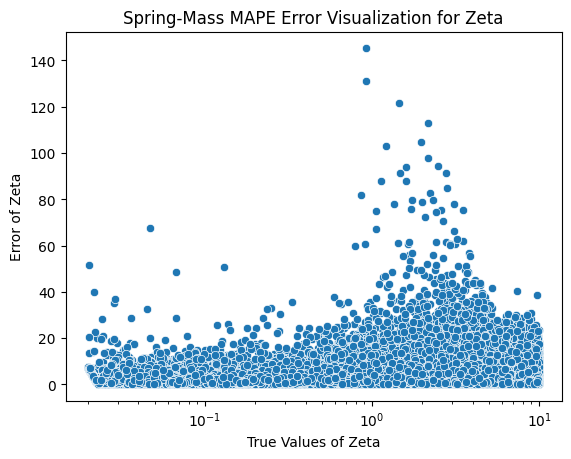

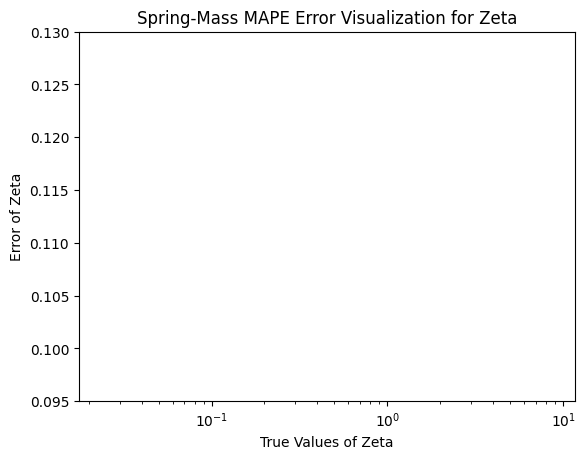

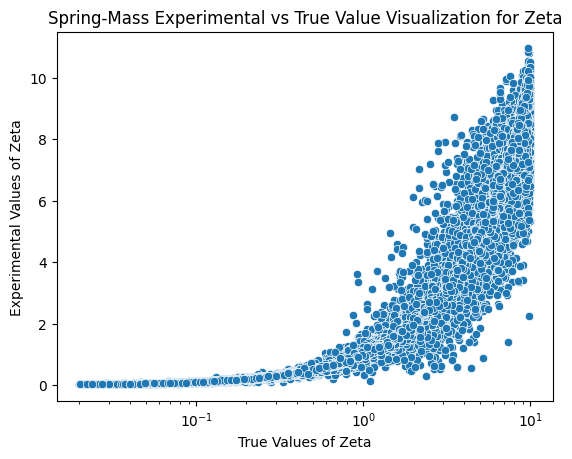

Size of True Values 80000
Negative Numbers 0
-1.3979792417258974 -0.022302707073471765
bin_edges
[0.03999639 0.04686025 0.05490203 0.06432388 0.07536263 0.08829577
 0.10344839 0.12120137 0.14200099 0.16637007 0.19492118 0.228372
 0.26756338 0.31348048 0.36727751 0.43030675 0.50415257 0.59067122
 0.69203752 0.81079949 0.94994244]
Min:  0.03999638666541335
Max:  0.9499424446129795
Shirley printing bin_edges
[0.03999639 0.04686025 0.05490203 0.06432388 0.07536263 0.08829577
 0.10344839 0.12120137 0.14200099 0.16637007 0.19492118 0.228372
 0.26756338 0.31348048 0.36727751 0.43030675 0.50415257 0.59067122
 0.69203752 0.81079949 0.94994244]
Shirley is done printing bin_edges
True values plot: [0.6392712343726102, 0.29156596025879283, 0.7484226632181812, 0.5479162394486328, 0.07449488314037114, 0.9134963561169105, 0.6234932715997246, 0.6543585933326334, 0.08953683653614312, 0.30127259203679746, 0.23739146807085504, 0.8425798884141426, 0.4882743867992035, 0.7011597011203076, 0.2953729184770666

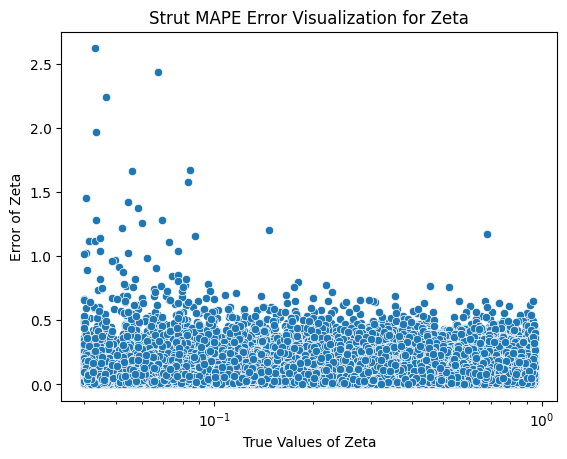

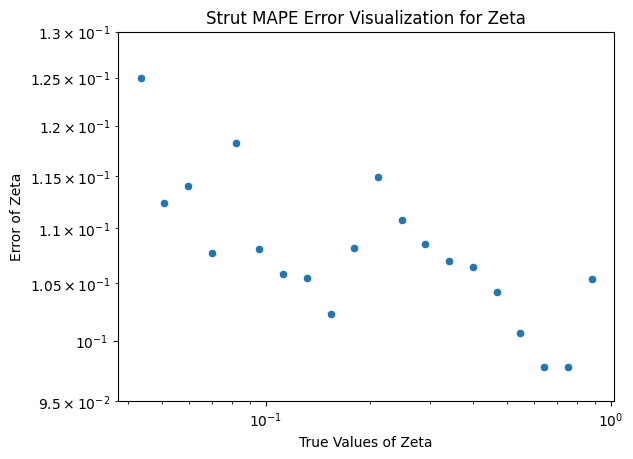

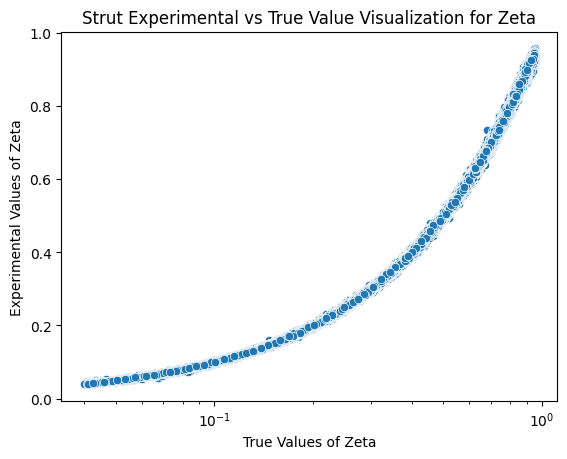

In [124]:
import keras

#modelLSTMDisturb = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/modelLSTMDisturbFinal.keras")
#modelDeepDamping = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/modelDeepDampingFinal.keras")
#y_predSPRINGLSTM = modelLSTMDisturb.predict(x_test)
#y_predSPRINGDeep = modelDeepDamping.predict(x_test)

'''
print(f"Mean Absolute Percentage Error of Springmass Damping Model: {modelDeepDamping1114.evaluate(x_test, y_test[:,:1])}")
mapeLSTM = mean_absolute_percentage_error(y_test[:,1:], y_predLSTM)
print(f'Mean Absolute Percentage Error of Springmass Disturbance Model: {mapeLSTM}')
'''



##visualizeSpecificError(step1modelDAMP, x_testOLD, y_testOLD,"mape")
#visualizeSpecificRelationship(step1modelDAMP, x_testOLD, y_testOLD, "mape")

#visualizeSpecificError(y_testSpring[:,1:],y_predSPRINGLSTM,"mse","Spring-Mass")
#visualizeSpecificRelationship(y_testSpring[:,1:], y_predSPRINGLSTM, "mse","Spring-Mass")

visualizeSpecificError(y_testSpring[:,:1],y_predSPRINGDeep,"mape","Spring-Mass")
visualizeSpecificRelationship(y_testSpring[:,:1],y_predSPRINGDeep, "mape","Spring-Mass")

'''
outputsCOMBINED = np.concatenate((y_predDeep, y_predLSTM), axis=1)
visualizeNormGraphing(y_predDeep, y_test[:,:1], "Spring-Mass_Damping")
visualizeNormGraphing(y_predLSTM, y_test[:,1:], "Spring-Mass_Disturbance")
visualizeNormGraphing(outputsCOMBINED, y_test, "Spring-Mass_Damping_&_Disturbance")
'''
####strut start####
#print(f"Mean Absolute Percentage Error of Strut Damping Model: {modelDeepDamping1114.evaluate(x_testStrutNEW, y_testStrutNEW[:,:1])}") 

#mapeLSTMStrut = mean_absolute_percentage_error(y_testStrutNEW[:,1:], y_predLSTM)
#print(f'Mean Absolute Percentage Error of Strut Disturbance Model: {mapeLSTMStrut}')

#visualizeSpecificError(y_testStrut[:,1:],y_predLSTM,"mse","Strut")
#visualizeSpecificRelationship(y_testStrut[:,1:], y_predLSTM,"mse","Strut")

visualizeSpecificError(y_testStrut[:,:1],y_predDeep,"mape","Strut")
visualizeSpecificRelationship(y_testStrut[:,:1], y_predDeep, "mape","Strut")




#outputsCOMBINEDStrut = np.concatenate((y_predDeep, y_predLSTM), axis=1)
#visualizeNormGraphing(y_predDeep, y_testStrut[:,:1], "Strut_Damping")
#visualizeNormGraphing(y_predLSTM, y_testStrut[:,1:], "Strut_Disturbance")
#visualizeNormGraphing(outputsCOMBINEDStrut, y_testStrut, "Strut_Damping_&_Strut_Disturbance")


#idea: try to find what systems and time history where the omega is really bad 
# (where omega is around 0.25 and around its natural frequency)

#outputsDampPart1 = step1modelDAMP.predict(x_testOLD)
#visualizeNormGraphing(outputsDampPart1, y_testOLD, "Damping")

#visualizeAmplitudeError(y_testSpring[:,2:6], y_predSPRINGLSTM[:,1:5],"Spring-Mass")
#visualizeAmplitudeError(y_testStrut[:,2:6], y_predLSTM[:,1:5],"Strut")

#visualizeAmpitudeEvT(modelLSTMDisturb, x_test, y_test[:,1:5], "Spring-Mass")
#visualizeAmpitudeEvT(modelStrutLSTMDisturb, x_testStrut, y_testStrut[:,1:5], "Strut")





In [ ]:
outputsDAMPINGStrut = modelStrutDeepDamping.predict(x_testStrut) #array of arrays
outputsDISTURBANCEStrut = modelStrutLSTMDisturb.predict(x_testStrut)
outputsCOMBINEDStrut = np.concatenate((outputsDAMPINGStrut, outputsDISTURBANCEStrut), axis=1)
visualizeNormGraphing(outputsDAMPINGStrut, y_testStrut[:,:1], "Strut Damping")
visualizeNormGraphing(outputsDISTURBANCEStrut, y_testStrut[:,1:], "Strut Disturbance")
visualizeNormGraphing(outputsCOMBINEDStrut, y_testStrut, "Strut Damping & Strut Disturbance")

In [6]:
import keras 
modelLSTMDisturb = keras.saving.load_model("/Users/tristancarter/Springmass_Project/trained_models/modelLSTMDisturbFinal.keras")
modelLSTMDisturb.evaluate(x_test, y_test[:,1:])

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 228s 91ms/step - loss: 0.0010


0.0010648993775248528